In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Dataset/train.ft.txt.bz2.zip" -d "/content/Amazon Reviews"

Archive:  /content/drive/MyDrive/Dataset/train.ft.txt.bz2.zip
  inflating: /content/Amazon Reviews/train.ft.txt.bz2  


In [4]:
import bz2 as bz2
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

%matplotlib inline

In [6]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('/content/Amazon Reviews/train.ft.txt.bz2')

In [7]:
from sklearn.model_selection import train_test_split
labels_train,discard_labels,texts_train,discard_texts = train_test_split(train_labels,train_texts,
                                                 test_size = 0.95,
                                                 random_state = 2021)

In [8]:
train_txts = []
for text in texts_train:
    text = text.lower() #Convert to lower case
    text = re.sub('[^a-zA-Z ]','',text)
    text = text.split()
    text = ' '.join(text)
    train_txts.append(text)


In [9]:
print(len(train_txts))
print(len(labels_train))

180000
180000


In [10]:
from sklearn.model_selection import train_test_split
train_txts2, val_texts, train_labels2, val_labels = train_test_split(
    train_txts, labels_train, test_size=0.2)

In [11]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    train_txts, labels_train, test_size=0.4)

In [12]:
print(len(train_texts))
print(len(val_texts))
print(len(train_labels))
print(len(val_labels ))
print(len(test_texts))
print(len(test_labels))

type(train_texts)


108000
36000
108000
36000
72000
72000


list

In [13]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

In [16]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'i': 3,
 'a': 4,
 'to': 5,
 'of': 6,
 'it': 7,
 'this': 8,
 'is': 9,
 'in': 10,
 'for': 11,
 'that': 12,
 'was': 13,
 'not': 14,
 'you': 15,
 'with': 16,
 'but': 17,
 'on': 18,
 'book': 19,
 'have': 20,
 'my': 21,
 'as': 22,
 'are': 23,
 'one': 24,
 'be': 25,
 'so': 26,
 'all': 27,
 'great': 28,
 'if': 29,
 'very': 30,
 'good': 31,
 'like': 32,
 'they': 33,
 'its': 34,
 'at': 35,
 'from': 36,
 'just': 37,
 'or': 38,
 'would': 39,
 'an': 40,
 'about': 41,
 'out': 42,
 'me': 43,
 'has': 44,
 'what': 45,
 'had': 46,
 'more': 47,
 'will': 48,
 'when': 49,
 'get': 50,
 'read': 51,
 'by': 52,
 'no': 53,
 'up': 54,
 'time': 55,
 'only': 56,
 'your': 57,
 'there': 58,
 'dont': 59,
 'can': 60,
 'movie': 61,
 'he': 62,
 'his': 63,
 'really': 64,
 'some': 65,
 'do': 66,
 'than': 67,
 'them': 68,
 'who': 69,
 'much': 70,
 'well': 71,
 'even': 72,
 'first': 73,
 'other': 74,
 'we': 75,
 'her': 76,
 'these': 77,
 'after': 78,
 'were': 79,
 'love': 80,
 'because': 81,
 'too': 8

In [17]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

In [18]:
def build_model():
    
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.Conv1D(64, 3, activation='relu')(embedded)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(3)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(5)(x)
    x = layers.Conv1D(64, 5, activation='relu')(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model
    
model = build_model()

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 212)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 212, 64)           768000    
_________________________________________________________________
conv1d (Conv1D)              (None, 210, 64)           12352     
_________________________________________________________________
batch_normalization (BatchNo (None, 210, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 66, 64)            20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 64)            256   

In [51]:
model_cnn =model.fit(
          train_texts, 
          train_labels, 
          batch_size=128,
          epochs=2,
          validation_data=(val_texts, val_labels), )

Epoch 1/2
844/844 [==============================] - 16s 19ms/step - loss: 0.1342 - binary_accuracy: 0.9512 - val_loss: 0.2089 - val_binary_accuracy: 0.9282
Epoch 2/2
844/844 [==============================] - 16s 19ms/step - loss: 0.0917 - binary_accuracy: 0.9680 - val_loss: 0.2327 - val_binary_accuracy: 0.9171


In [67]:
model.save_weights("cnn_model.h5")

In [21]:
preds = model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

Accuracy score: 0.9114
F1 score: 0.9077
ROC AUC score: 0.9758


<h1>RNN</h1>

In [22]:
def build_rnn_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    return model
    
rnn_model = build_rnn_model()

In [23]:
rnn_model.fit(
    train_texts, 
    train_labels, 
    batch_size=128,
    epochs=1,
    validation_data=(val_texts, val_labels), )

844/844 [==============================] - 80s 91ms/step - loss: 0.3328 - binary_accuracy: 0.8568 - val_loss: 0.2029 - val_binary_accuracy: 0.9211


In [68]:
rnn_model.save_weights("rnn_model.h5")

In [24]:
preds = rnn_model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

Accuracy score: 0.9144
F1 score: 0.9137
ROC AUC score: 0.9714


<h1>GRU</h1>

In [34]:

from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline

In [35]:
from tensorflow.keras.layers import GRU

gru_model = Sequential()
gru_model.add(Embedding(MAX_FEATURES,64))
gru_model.add(GRU(32))
gru_model.add(Dense(1,activation='sigmoid'))

In [36]:
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          768000    
_________________________________________________________________
gru (GRU)                    (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 777,441
Trainable params: 777,441
Non-trainable params: 0
_________________________________________________________________


In [37]:
gru_model.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics =  ['accuracy'])

gru_train_results = gru_model.fit(train_texts, 
    train_labels,validation_split = 0.1,
                                  epochs = 10,
                                  batch_size = 32)

Epoch 1/10
3038/3038 [==============================] - 111s 36ms/step - loss: 0.2819 - accuracy: 0.8819 - val_loss: 0.2207 - val_accuracy: 0.9131
Epoch 2/10
3038/3038 [==============================] - 108s 35ms/step - loss: 0.1968 - accuracy: 0.9234 - val_loss: 0.1986 - val_accuracy: 0.9215
Epoch 3/10
3038/3038 [==============================] - 108s 36ms/step - loss: 0.1779 - accuracy: 0.9311 - val_loss: 0.1969 - val_accuracy: 0.9248
Epoch 4/10
3038/3038 [==============================] - 108s 35ms/step - loss: 0.1644 - accuracy: 0.9377 - val_loss: 0.1902 - val_accuracy: 0.9264
Epoch 5/10
3038/3038 [==============================] - 108s 36ms/step - loss: 0.1531 - accuracy: 0.9420 - val_loss: 0.1881 - val_accuracy: 0.9262
Epoch 6/10
3038/3038 [==============================] - 107s 35ms/step - loss: 0.1426 - accuracy: 0.9472 - val_loss: 0.1868 - val_accuracy: 0.9244
Epoch 7/10
3038/3038 [==============================] - 108s 36ms/step - loss: 0.1328 - accuracy: 0.9513 - val_loss: 0

In [71]:
gru_model.save_weights("gru_model.h5")

In [39]:
loss, accuracy = gru_model.evaluate(test_texts,test_labels)

2250/2250 [==============================] - 31s 14ms/step - loss: 0.2004 - accuracy: 0.9264


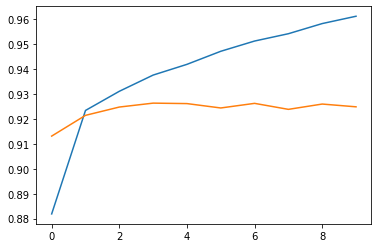

In [40]:
plt.plot(gru_train_results.history['accuracy'])
plt.plot(gru_train_results.history['val_accuracy'])
plt.show()

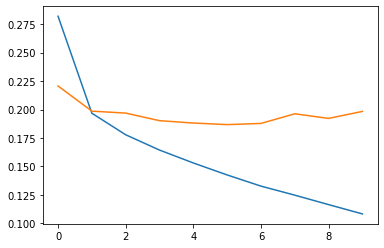

In [41]:
plt.plot(gru_train_results.history['loss'])
plt.plot(gru_train_results.history['val_loss'])
plt.show()

<h1>LSTM</h1>

In [43]:
from tensorflow.keras.layers import LSTM
lstm_model = Sequential()
lstm_model.add(Embedding(MAX_FEATURES,64))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1,activation='sigmoid'))

In [44]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          768000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 780,449
Trainable params: 780,449
Non-trainable params: 0
_________________________________________________________________


In [45]:
lstm_model.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics =  ['accuracy'])

lstm_train_results = lstm_model.fit(train_texts, 
    train_labels,validation_split = 0.1,
                                  epochs = 10,
                                  batch_size = 32)

Epoch 1/10
3038/3038 [==============================] - 110s 36ms/step - loss: 0.2912 - accuracy: 0.8810 - val_loss: 0.2745 - val_accuracy: 0.8923
Epoch 2/10
3038/3038 [==============================] - 107s 35ms/step - loss: 0.2174 - accuracy: 0.9163 - val_loss: 0.2402 - val_accuracy: 0.9060
Epoch 3/10
3038/3038 [==============================] - 106s 35ms/step - loss: 0.1956 - accuracy: 0.9253 - val_loss: 0.2115 - val_accuracy: 0.9147
Epoch 4/10
3038/3038 [==============================] - 107s 35ms/step - loss: 0.1798 - accuracy: 0.9319 - val_loss: 0.1982 - val_accuracy: 0.9211
Epoch 5/10
3038/3038 [==============================] - 106s 35ms/step - loss: 0.1673 - accuracy: 0.9372 - val_loss: 0.2002 - val_accuracy: 0.9206
Epoch 6/10
3038/3038 [==============================] - 107s 35ms/step - loss: 0.1558 - accuracy: 0.9425 - val_loss: 0.1977 - val_accuracy: 0.9240
Epoch 7/10
3038/3038 [==============================] - 107s 35ms/step - loss: 0.1461 - accuracy: 0.9466 - val_loss: 0

In [70]:
lstm_model.save_weights("lstm_model.h5")

In [47]:
loss, accuracy = lstm_model.evaluate(test_texts,test_labels)

2250/2250 [==============================] - 31s 13ms/step - loss: 0.2018 - accuracy: 0.9226


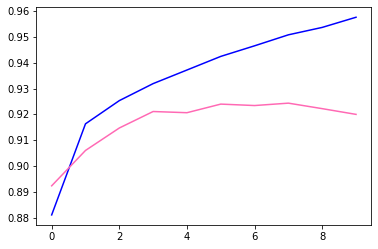

In [48]:
plt.plot(lstm_train_results.history['accuracy'],c='blue')
plt.plot(lstm_train_results.history['val_accuracy'],c='hotpink')
plt.show()

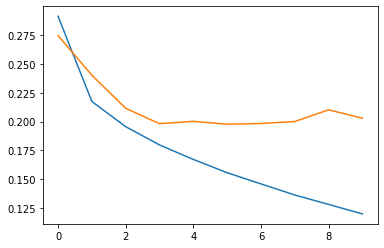

In [49]:
plt.plot(lstm_train_results.history['loss'])
plt.plot(lstm_train_results.history['val_loss'])
plt.show()